<b><p style="font-size: XX-large"><font color = "green">Andrew Cai (cai.and@northeastern.edu)</font></p></b> </div>
<b><p style="font-size: XX-large"><font color = "green">Joynae Whitehurst  (whitehurst.j@northeastern.edu)</font></p></b> </div>
<b><p style="font-size: XX-large"><font color = "green">DS5110: Essentials of Data Science</font></p></b> </div>
<b><p style="font-size: XX-large"><font color = "green">Anomaly Detection and Alternative Recommendations for Music Playlists</font></p></b> </div>
<b><p style="font-size: XX-large"><font color = "green">December 01, 2025</font></p></b> </div>


# Dataset Sources


- playlist dataset (playlist_dataset.csv): https://www.kaggle.com/datasets/andrewmvd/spotify-playlists
- songs dataset (song_dataset.csv): https://www.kaggle.com/datasets/rodolfofigueroa/spotify-12m-songs

# Import Packages

In [1]:
# Python Imports/dataset handling
import pandas as pd
import numpy as np
import re
import string
from pathlib import Path
from tqdm import tqdm
import csv
import ast

# Anomaly Detection and Reccomendation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

# Visualizations
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Clean warnings
import warnings
warnings.filterwarnings("ignore")

# Process and Load Data

In [2]:
# Read in data that has real playlists
df_playlist = pd.read_csv(
    "playlist_dataset.csv",
    sep=",",
    quotechar='"',
    quoting=csv.QUOTE_MINIMAL,
    engine="python",
    on_bad_lines="skip"   # skip bad rows (rare)
)

# rename to easier names
df_playlist.columns = ["user_id", "artist", "track", "playlist"]

df_playlist = df_playlist[["artist", "track", "playlist"]]
df_playlist.head()

,artist,track,playlist
0,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,Elvis Costello,Alison,HARD ROCK 2010


In [3]:
def normalize_text(s):
    """Normalizing a string in order to easier processing

    Args:
        s (string): Any string

    Returns:
        string: Normalized string
    """
    if pd.isna(s): return ""
    s = s.lower().strip()

    # remove stuff like (feat. X), [feat. X], "feat. X", "ft. X"
    s = re.sub(r"\(feat.*?\)|\[feat.*?\]|feat\..*|ft\..*", "", s)

    # remove punctuation
    s = s.translate(str.maketrans("", "", string.punctuation))

    # collapse spaces
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Normalize artist and track names (track names = song titles)
df_playlist["artist_norm"] = df_playlist["artist"].apply(normalize_text)
df_playlist["track_norm"] = df_playlist["track"].apply(normalize_text)

In [4]:
# Load in a list of songs with features
df_song = pd.read_csv('song_dataset.csv')
df_song.head(5)

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],1,1,False,0.470,...,0.0727,0.02610,0.000011,0.3560,0.503,117.906,210133,4.0,1999,1999-11-02
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],2,1,True,0.599,...,0.1880,0.01290,0.000071,0.1550,0.489,103.680,206200,4.0,1999,1999-11-02
2,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],3,1,False,0.315,...,0.4830,0.02340,0.000002,0.1220,0.370,149.749,298893,4.0,1999,1999-11-02
3,2lbASgTSoDO7MTuLAXlTW0,Mic Check,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],4,1,True,0.440,...,0.2370,0.16300,0.000004,0.1210,0.574,96.752,213640,4.0,1999,1999-11-02
4,1MQTmpYOZ6fcMQc56Hdo7T,Sleep Now In the Fire,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],5,1,False,0.426,...,0.0701,0.00162,0.105000,0.0789,0.539,127.059,205600,4.0,1999,1999-11-02


In [5]:
# Clean song data, artists column is a string representation of a list
def parse_artists(x):
    """Parse the artists column which is a string representation of a list

    Args:
        x (string): String representation of a list of artists

    Returns:
        string: A single string with artists joined by spaces
    """
    if pd.isna(x): return ""
    try:
        lst = ast.literal_eval(x)  # converts string list → list
        if isinstance(lst, list):
            return " ".join(lst)
        return str(lst)
    except:
        return str(x)


# Clean and normalize artist and track names in song dataset
df_song["artists_clean"] = df_song["artists"].apply(parse_artists)
df_song["artist_norm"] = df_song["artists_clean"].apply(normalize_text)
df_song["track_norm"]  = df_song["name"].apply(normalize_text)

In [6]:
# Find matching songs from playlist to song
df_join = df_playlist.merge(
    df_song,
    on=["track_norm", "artist_norm"],
    how="left"
)

In [7]:
# How many songs match between playlist and song dataset?
match_rate = df_join["id"].notna().mean()
print(f"Match rate: {match_rate:.2%}")

# Keep only songs with matches
df_matched = df_join[df_join["id"].notna()].copy()
print("Matched rows:", len(df_matched))

Match rate: 22.59%
Matched rows: 3173308


In [8]:
# How many matched songs per playlist?
matched_counts = df_matched.groupby("playlist").size().sort_values(ascending=False)
matched_counts.head(10)

playlist
Starred                  333857
Liked from Radio          71727
Favoritas de la radio     13436
Rock                      10719
Christmas                 10127
80s                        9309
Oldies                     9033
80's                       8469
90s                        6068
Classic Rock               5681
dtype: int64

In [9]:
# Retrieve playlists with between 20 and 30 matched songs
good_playlists = matched_counts[(matched_counts >= 20) & (matched_counts <= 30)].index
# Filter matched songs to only those playlists
df_matched_2030 = df_matched[df_matched["playlist"].isin(good_playlists)].copy()

print("playlists 20 <= songs <= 30 matched:", len(good_playlists))
print("rows in those playlists:", len(df_matched_2030))

playlists 20 <= songs <= 30 matched: 7862
rows in those playlists: 192249


In [10]:
# Retrieve relevant features and keep rows that have non-nulls
vibe_features = [
    "danceability","energy","valence","tempo","loudness",
    "speechiness","acousticness","instrumentalness","liveness",
    "mode","duration_ms"
    ]

# Keep only rows with all vibe features non-null
df_work = df_matched_2030.dropna(subset=vibe_features).copy()

print("rows with all features:", len(df_work))
print("unique playlists:", df_work["playlist"].nunique())

rows with all features: 192249
unique playlists: 7862


# Find Anomalies

In [11]:
def score_playlist_centroid(g):
    """Calculate anomaly scores for songs in a playlist based on their distance from the playlist centroid.

    Args:
        g (DataFrame): Group of songs belonging to a single playlist.

    Returns:
        DataFrame: The input DataFrame with added anomaly score and z-score columns.
    """
    # Extract feature values for the group
    X = g[vibe_features].values
    
    # Standardize features
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    # Compute centroid and distances
    centroid = Xs.mean(axis=0, keepdims=True)
    d = cosine_distances(Xs, centroid).ravel()
    
    # Prepare output DataFrame
    out = g.copy()
    # Add anomaly scores
    out["anomaly_score"] = d
    # Calculate z-scores
    std = d.std()
    out["anomaly_z"] = (d - d.mean()) / (std if std > 1e-9 else 1.0)  # optional safety
    return out

# Apply scoring function to each playlist
df_scored = df_work.groupby("playlist", group_keys=False).apply(score_playlist_centroid)

# Identify anomalies based on z-score threshold
anomalies = df_scored[df_scored["anomaly_z"] > 1.8].sort_values(["playlist","anomaly_score"], ascending=[True,False])
anomalies[["playlist","artist","track","anomaly_score","anomaly_z"]]

,playlist,artist,track,anomaly_score,anomaly_z
8516943,groove,Duran Duran,Notorious,1.612757,1.861862
8516944,groove,Duran Duran,Notorious,1.612757,1.861862
8516945,groove,Duran Duran,Notorious,1.612757,1.861862
8516946,groove,Duran Duran,Notorious,1.612757,1.861862
4427165,#ChicifyShoppingParty,The Kooks,Naive,1.482025,1.897954
...,...,...,...,...,...
8784159,till Linnea,Chaka Khan,Ain't Nobody,1.419423,2.449490
9375363,tribe vibe,A Tribe Called Quest,Verses From the Abstract,1.742366,1.832144
1572055,"welcome, max",Ben E. King,Stand By Me,1.605517,2.353094
8097132,xmas mix,She & Him,Rockin' Around the Christmas Tree,1.534368,1.844138


## Retrieve Playlists With Highest Anomalies

In [12]:
def top_anomaly_playlists(df_scored, z_thresh=1.8, top_n=5):
    """Identify the top N playlists ranked by their maximum anomaly_z score.

    Args:
        df_scored (DataFrame): DataFrame containing scored playlist data.
        z_thresh (float, optional): Z-score threshold for filtering anomalies. Defaults to 1.8.
        top_n (int, optional): Number of top playlists to return. Defaults to 5.

    Returns:
        tuple: A tuple containing the list of top playlists and a dictionary of anomalies per playlist.
    """
    # compute max anomaly_z per playlist
    max_z = df_scored.groupby("playlist")["anomaly_z"].max()
    
    # filter by threshold
    eligible = max_z[max_z > z_thresh]
    
    if eligible.empty:
        return [], {}
    
    # sort descending and select top_n
    top_playlists = eligible.sort_values(ascending=False).head(top_n).index.tolist()
    
    # extract anomalies per playlist
    playlist_anom_dict = {}
    for pl in top_playlists:
        df_pl = df_scored[df_scored["playlist"] == pl]
        
        df_anoms = df_pl[df_pl["anomaly_z"] > z_thresh] \
            .sort_values("anomaly_z", ascending=False)
        
        playlist_anom_dict[pl] = df_anoms[[
            "artist","track","anomaly_score","anomaly_z"
        ]].copy()
    
    return top_playlists, playlist_anom_dict

In [13]:
# Example usage of top_anomaly_playlists
top_playlists, anom_data = top_anomaly_playlists(
    df_scored,
    z_thresh=1.8,
    top_n=10
)

print("Top playlists with anomalies:")
for pl in top_playlists:
    print(pl)

Top playlists with anomalies:
[500] Days Of Summer - Music From The Motion Picture – [500] Days Of Summer - Music From The Motion Picture
better 80s
Rihanna
Mars 2010¨
British Girls
Strip to you [ ♥ ]
Entspann dich, Dude!
Sat Nights @ Nells w/ Michelle & Eugene
prov åk 8
Anna Ternheim - The Night Visitor


# Helper Functions

## Global Variables

In [14]:
# candidate pool (global songs with features)
global_df = df_song.dropna(subset=vibe_features).copy()

# scale global songs once
global_scaler = StandardScaler()
global_Xs = global_scaler.fit_transform(global_df[vibe_features])

## Recommnedations and Analysis Helper Functions

In [15]:
def analyze_playlist_and_recommend_visual(
    playlist_name,
    df_work,
    global_df,
    global_scaler,
    global_Xs,
    vibe_features,
    z_thresh=1.8,
    rec_topn=5,
    max_anoms=3,
    ):
    """Analyze a playlist for anomalies and recommend replacement songs based on playlist vibe.

    Args:
        playlist_name (string): Name of the playlist to analyze.
        df_work (DataFrame): DataFrame containing reliable playlist data.
        global_df (DataFrame): Candidate pool (global songs with features)
        global_scaler (StandardScaler): Scaler fitted on global features
        global_Xs (ndarray): Scaled global feature matrix
        vibe_features (list): List of feature names used for vibe analysis
        z_thresh (float, optional): Z-score threshold for anomaly detection. Defaults to 1.8.
        rec_topn (int, optional): Number of top recommendations to return. Defaults to 5.
        max_anoms (int, optional): Maximum number of anomalies to return. Defaults to 3.

    Returns:
        dict: Dictionary containing analysis results including anomalies and recommendations.
    """
    # isolate playlist
    g = df_work[df_work["playlist"] == playlist_name].copy()
    if g.empty:
        return {"playlist": playlist_name, "error": "Playlist not found in df_work."}

    # anomaly scoring (centroid cosine distance)
    X = g[vibe_features].values
    scaler_pl = StandardScaler()
    Xs = scaler_pl.fit_transform(X)
    # Calculate centroid of the scaled features
    centroid = Xs.mean(axis=0, keepdims=True)
    d = cosine_distances(Xs, centroid).ravel()
    # add scores to DataFrame
    g["anomaly_score"] = d
    g["anomaly_z"] = (d - d.mean()) / (d.std() + 1e-9)

    # anomalies
    anoms = (
        g[g["anomaly_z"] > z_thresh]
        .sort_values("anomaly_score", ascending=False)
        .head(max_anoms)
    )
    # if no anomalies, return early
    if anoms.empty:
        return {
            "playlist": playlist_name,
            "playlist_df": g,
            "anomalies_df": anoms,
            "recommendations_df": None,
            "note": f"No anomalies above z_thresh={z_thresh}.",
        }

    # playlist centroid in GLOBAL feature space for recs
    pl_Xs_global = global_scaler.transform(g[vibe_features].values)
    pl_centroid_global = pl_Xs_global.mean(axis=0, keepdims=True)
    # compute cosine similarity to playlist centroid
    sims = cosine_similarity(global_Xs, pl_centroid_global).ravel()

    # exclude songs already in playlist
    in_pl_ids = set(g["id"].dropna())
    cand = global_df.copy()
    cand["sim_to_playlist"] = sims
    cand = cand[~cand["id"].isin(in_pl_ids)]

    # keep id + vibe features for plotting
    keep_cols = ["id", "name", "artists_clean", "sim_to_playlist", "year"] + vibe_features
    top_cands = cand.sort_values("sim_to_playlist", ascending=False).head(rec_topn)

    return {
        "playlist": playlist_name,
        "playlist_df": g,
        "anomalies_df": anoms[["artist", "track", "anomaly_score", "anomaly_z"]],
        "recommendations_df": top_cands[keep_cols],
    }


def demo_random_playlist_visual(
    df_work,
    df_scored,
    global_df,
    global_scaler,
    global_Xs,
    vibe_features,
    z_thresh=1.8,
    require_anomalies=False,
    rec_topn=5,
    max_anoms=3,
    ):
    """Picks a playlist (random or only those with anomalies), analyzes it,
       prints anomalies/recommendations, and returns the analyzer output dict.

    Args:
        df_work (DataFrame): DataFrame containing working playlist data.
        df_scored (DataFrame): DataFrame containing scored playlist data.
        global_df (DataFrame): DataFrame containing global song data.
        global_scaler (Scaler): Scaler object for global features.
        global_Xs (ndarray): Scaled global feature matrix.
        vibe_features (list): List of vibe feature column names.
        z_thresh (float, optional): Z-score threshold for anomaly detection. Defaults to 1.8.
        require_anomalies (bool, optional): Whether to only select playlists with anomalies. Defaults to False.
        rec_topn (int, optional): Number of top recommendations to return. Defaults to 5.
        max_anoms (int, optional): Maximum number of anomalies to consider. Defaults to 3.

    Returns:
        dict: Dictionary containing analysis results including playlist, anomalies, and recommendations.
    """

    # Pick playlist
    if require_anomalies:
        # playlists that have at least one anomaly > z_thresh
        playlists_with_anoms = (
            df_scored.groupby("playlist")["anomaly_z"]
            .max()
            .loc[lambda s: s > z_thresh]
            .index
        )
        if len(playlists_with_anoms) == 0:
            print("No playlists with anomaly > z_thresh.")
            return None
        # pick from those playlists only
        pl = pd.Series(playlists_with_anoms).sample(1).iloc[0]
    else:
        # pick from all available playlists in df_work
        pl = pd.Series(df_work["playlist"].unique()).sample(1).iloc[0]

    print("\n🎵 Selected playlist:", pl)

    # Run the main analyzer
    out = analyze_playlist_and_recommend_visual(
        pl,
        df_work=df_work,
        global_df=global_df,
        global_scaler=global_scaler,
        global_Xs=global_Xs,
        vibe_features=vibe_features,
        z_thresh=z_thresh,
        rec_topn=rec_topn,
        max_anoms=max_anoms,
    )

    # Show results
    if "error" in out:
        print("Error:", out["error"])
        return out

    if out["anomalies_df"].empty:
        print("\nNo anomalies above z =", z_thresh)
        return out

    print("\nAnomalies found:")
    display(out["anomalies_df"])

    print("\nRecommended replacements (playlist vibe):")
    display(out["recommendations_df"])

    return out



## Plot Helper Functions

In [16]:
def plot_playlist_pca(playlist_df, playlist_name, vibe_features, z_thresh=1.8):
    """Plot PCA visualization of playlist vibe features, highlighting anomalies.

    Args:
        playlist_df (DataFrame): DataFrame containing playlist data.
        playlist_name (str): Name of the playlist.
        vibe_features (List): List of vibe feature column names.
        z_thresh (float, optional): Z-score threshold for anomaly detection. Defaults to 1.8.
    """
    # Prepare data
    df = playlist_df.copy()
    X = df[vibe_features].values
    # Perform PCA
    pca = PCA(n_components=2)
    X2 = pca.fit_transform(X)
    # Add PCA components and anomaly flag to DataFrame
    df["pc1"] = X2[:, 0]
    df["pc2"] = X2[:, 1]
    df["is_anomaly"] = df["anomaly_z"] > z_thresh
    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(
        df["pc1"],
        df["pc2"],
        c=df["is_anomaly"].map({True: "red", False: "blue"}),
        alpha=0.8,
    )

    # label anomalies
    for _, r in df[df["is_anomaly"]].iterrows():
        plt.text(r["pc1"], r["pc2"], r["track"], fontsize=9)

    plt.title(f"PCA Vibe Map – {playlist_name}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()


def plot_anomaly_bars(playlist_df, playlist_name, z_thresh=1.8):
    """Plot horizontal bar chart of anomaly z-scores for playlist tracks.

    Args:
        playlist_df (DataFrame): DataFrame containing playlist data.
        playlist_name (str): Name of the playlist.
        z_thresh (float, optional): Z-score threshold for anomaly detection. Defaults to 1.8.
    """
    # Prepare data
    df = playlist_df.copy()
    df = df.sort_values("anomaly_z", ascending=False)
    # Determine bar colors based on anomaly status
    colors = ["red" if z > z_thresh else "blue" for z in df["anomaly_z"]]
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(df["track"], df["anomaly_z"], color=colors)
    plt.xlabel("Anomaly Z-Score")
    plt.title(f"Anomaly Scores – {playlist_name}")
    plt.gca().invert_yaxis()
    plt.show()


def plot_feature_distributions(playlist_df, playlist_name, vibe_features, z_thresh=1.8):
    """Plot distributions of vibe features, highlighting anomalies.

    Args:
        playlist_df (DataFrame): DataFrame containing playlist data.
        playlist_name (str): Name of the playlist.
        vibe_features (List): List of vibe feature column names.
        z_thresh (float, optional): Z-score threshold for anomaly detection. Defaults to 1.8.
    """
    # Prepare data
    df = playlist_df.copy()
    anoms = df[df["anomaly_z"] > z_thresh]
    # Plot
    fig, axes = plt.subplots(len(vibe_features), 1, figsize=(8, 3 * len(vibe_features)))
    # Handle case of single feature
    if len(vibe_features) == 1:
        axes = [axes]  # make iterable
    # Plot histograms with anomalies highlighted
    for i, feat in enumerate(vibe_features):
        axes[i].hist(df[feat], bins=20, edgecolor="black")
        if not anoms.empty:
            axes[i].scatter(
                anoms[feat],
                [0] * len(anoms),
                color="red",
                marker="x",
                label="anomalies",
            )
            axes[i].legend()
        axes[i].set_title(feat)

    plt.tight_layout()
    plt.show()


In [17]:
def plot_all_for_playlist(out, vibe_features, z_thresh=1.8, anomaly_index=0, rec_index=0):
    """Given the output dict from analyze_playlist_and_recommend / demo_random_playlist,
       generate all visuals for the selected playlist.

    Args:
        out (Dict): Output dictionary from analyze_playlist_and_recommend / demo_random_playlist.
        vibe_features (List): List of vibe feature column names.
        z_thresh (float, optional): Z-score threshold for anomaly detection. Defaults to 1.8.
        anomaly_index (int, optional): Index of the anomaly to highlight. Defaults to 0.
        rec_index (int, optional): Index of the recommendation to highlight. Defaults to 0.
    """
    # Check for errors
    if "error" in out:
        print("Error:", out["error"])
        return
    # Extract data
    playlist_name = out["playlist"]
    playlist_df = out["playlist_df"]
    anomalies_df = out["anomalies_df"]
    recs_df = out["recommendations_df"]
    # Check for anomalies
    if anomalies_df is None or anomalies_df.empty:
        print("No anomalies to plot.")
        return

    # choose one anomaly (for radar/replacement)
    anomaly_row = anomalies_df.iloc[anomaly_index]
    # find full row in playlist_df to get vibe features
    anomaly_full = playlist_df[
        (playlist_df["track"] == anomaly_row["track"]) &
        (playlist_df["artist"] == anomaly_row["artist"])
    ].iloc[0]

    # choose one recommendation row
    if recs_df is None or recs_df.empty:
        print("No recommendations to plot.")
        rec_row = None
    else:
        rec_row = recs_df.iloc[rec_index]

    # Core plots
    plot_playlist_pca(playlist_df, playlist_name, vibe_features, z_thresh=z_thresh)
    plot_anomaly_bars(playlist_df, playlist_name, z_thresh=z_thresh)
    plot_feature_distributions(playlist_df, playlist_name, vibe_features, z_thresh=z_thresh)


## Comparison Helper Functions

In [18]:
def score_single_playlist(df, vibe_features, z_thresh=1.8):
    """Given a playlist DataFrame (rows are songs from ONE playlist),
       compute anomaly_score and anomaly_z and return:
        - scored_df: df with columns anomaly_score, anomaly_z
        - summary:   dict with playlist-level stats

    Args:
        df (DataFrame): Playlist DataFrame with songs.
        vibe_features (List[str]): List of vibe feature column names.
        z_thresh (float, optional): Z-score threshold for anomaly detection. Defaults to 1.8.

    Returns:
        tuple: (scored_df, summary)
    """
    # copy input
    g = df.copy()
    X = g[vibe_features].values
    # standardize features
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    # compute centroid and distances
    centroid = Xs.mean(axis=0, keepdims=True)
    d = cosine_distances(Xs, centroid).ravel()
    # add scores to DataFrame
    g["anomaly_score"] = d
    g["anomaly_z"] = (d - d.mean()) / (d.std() + 1e-9)

    # playlist-level summary
    summary = {
        "n_tracks": len(g),
        "mean_anomaly_z": float(g["anomaly_z"].mean()),
        "max_anomaly_z": float(g["anomaly_z"].max()),
        "min_anomaly_z": float(g["anomaly_z"].min()),
        "num_above_thresh": int((g["anomaly_z"] > z_thresh).sum()),
        "z_thresh": z_thresh,
    }

    return g, summary


def build_replaced_playlist(out, vibe_features, k=None):
    """Given 'out' from analyze_playlist_and_recommend_visuals, construct a new playlist
    where the top-k anomalies are replaced by the top-k recommended songs.

    Args:
        out (Dict): Output dictionary from analyze_playlist_and_recommend_visuals.
        vibe_features (List): List of vibe feature column names.
        k (int, optional): Top-k anomalies to replace. Defaults to None.

    Raises:
        ValueError: No anomalies to replace.
        ValueError: No recommendations available to use as replacements.
        ValueError: Missing vibe features in recommendations.

    Returns:
        tuple: (df_before, df_after) original playlist_df (no change) and new playlist df with replacements
    """
    playlist_df = out["playlist_df"].copy()
    anomalies_df = out["anomalies_df"].copy()
    recs_df = out["recommendations_df"].copy()
    # sanity checks
    if anomalies_df is None or anomalies_df.empty:
        raise ValueError("No anomalies to replace.")

    if recs_df is None or recs_df.empty:
        raise ValueError("No recommendations available to use as replacements.")

    # how many to replace
    if k is None:
        k = min(len(anomalies_df), len(recs_df))

    # pick top-k anomalies (highest anomaly_score)
    anomalies_df = anomalies_df.sort_values("anomaly_score", ascending=False).head(k)

    # build mask to drop those anomaly rows from playlist_df
    mask = pd.Series(False, index=playlist_df.index)
    for _, row in anomalies_df.iterrows():
        track = row["track"]
        artist = row["artist"]
        mask |= (playlist_df["track"] == track) & (playlist_df["artist"] == artist)

    df_before = playlist_df.copy()
    df_after = playlist_df[~mask].copy()

    # prepare k replacement songs from recs_df
    recs_k = recs_df.head(k).copy()

    # make column names consistent with playlist_df
    recs_k = recs_k.rename(columns={
        "name": "track",
        "artists_clean": "artist"
    })

    # assign playlist name to replacements
    pl_name = playlist_df["playlist"].iloc[0]
    recs_k["playlist"] = pl_name

    # ensure all vibe_features exist in recs_k (they should, from our earlier tweak)
    missing_feats = [f for f in vibe_features if f not in recs_k.columns]
    if missing_feats:
        raise ValueError(f"Missing vibe features in recommendations: {missing_feats}")

    # append replacements
    df_after = pd.concat([df_after, recs_k], ignore_index=True)

    return df_before, df_after


def compare_before_after(out, vibe_features, z_thresh=1.8, k=None):
    """Given 'out' from analyze_playlist_and_recommend_visuals, simulate replacing top-k anomalies
       with top-k recommended songs, then compare playlist anomaly stats before vs after.

    Args:
        out (Dict): Output dictionary from analyze_playlist_and_recommend_visuals.
        vibe_features (List): List of vibe feature column names.
        z_thresh (float, optional): Z-score threshold for anomaly detection. Defaults to 1.8.
        k (int, optional): Top-k anomalies to replace. Defaults to None.

    Returns:
        Dict: Dictionary containing scored and summary dataframes before and after replacement.
    """
    # check for errors
    if "error" in out:
        print("Error in out:", out["error"])
        return None

    if out["anomalies_df"] is None or out["anomalies_df"].empty:
        print("No anomalies to replace for this playlist.")
        return None
    
    # build replaced playlist
    df_before, df_after = build_replaced_playlist(out, vibe_features, k=k)
    # score before and after
    scored_before, summary_before = score_single_playlist(df_before, vibe_features, z_thresh=z_thresh)
    scored_after, summary_after = score_single_playlist(df_after, vibe_features, z_thresh=z_thresh)

    print(f"\nPlaylist: {out['playlist']}")
    print("Replacement count (k):", k if k is not None else len(out["anomalies_df"]))
    
    print("\nBefore replacement:")
    for k_b, v_b in summary_before.items():
        print(f"  {k_b}: {v_b}")

    print("\nAfter replacement:")
    for k_a, v_a in summary_after.items():
        print(f"  {k_a}: {v_a}")

    return {
        "scored_before": scored_before,
        "summary_before": summary_before,
        "scored_after": scored_after,
        "summary_after": summary_after,
    }


# Evaluation and Demonstration

## Anomaly Detection


🎵 Selected playlist: Belize Salad Days

Anomalies found:


,artist,track,anomaly_score,anomaly_z
5297661,Kings Of Leon,Use Somebody,1.694829,2.253006
5297632,Mac Demarco,Salad Days,1.622428,2.027837
5297662,Arcade Fire,Wake Up,1.582756,1.904458



Recommended replacements (playlist vibe):


,id,name,artists_clean,sim_to_playlist,year,danceability,energy,valence,tempo,loudness,speechiness,acousticness,instrumentalness,liveness,mode,duration_ms
751743,0qDuPjBrBCeUmyG3qN8rzP,Pipi auf Trip,Alkbottle,0.989679,1997,0.653,0.910,0.524,133.051,-4.037,0.0313,0.00157,0.000170,0.1080,1,228027
682209,1LFyIF4vZEaSxH99aSR033,Feel Like Dancing,Death Team,0.987468,2016,0.649,0.903,0.520,127.076,-4.425,0.0395,0.00150,0.000473,0.1360,1,203700
178336,3OJhpZOTQD32RtJGDZZ9KS,You Owe Me Some Kind of Love,Chris Isaak,0.987307,2006,0.654,0.902,0.520,125.505,-4.393,0.0282,0.00201,0.037400,0.1090,1,227947
873751,1JkTj4AUnDLq4hUVS8eYsP,A Love Like This,Thompson Square,0.983491,2018,0.650,0.856,0.461,125.992,-4.351,0.0397,0.02490,0.000000,0.1090,1,200387
419598,5cvuiP3kQ6Qhik83IUMXbd,Steel City,Kazzer,0.983404,2005,0.647,0.917,0.504,132.037,-4.624,0.0307,0.00291,0.000006,0.0807,1,220093


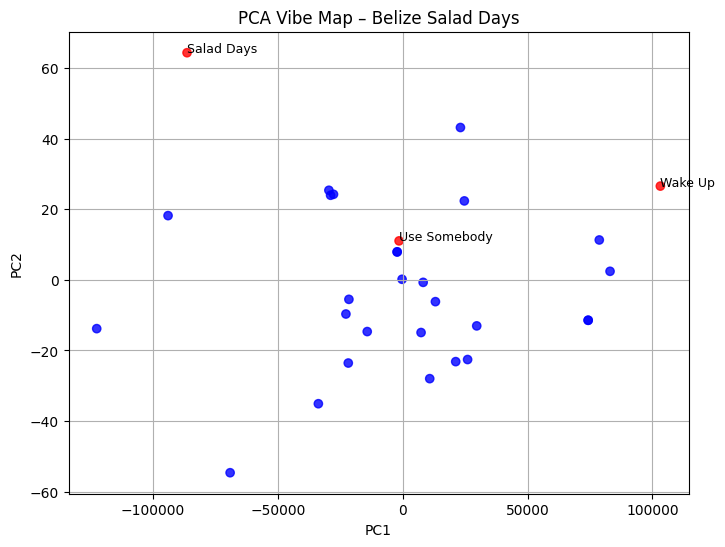

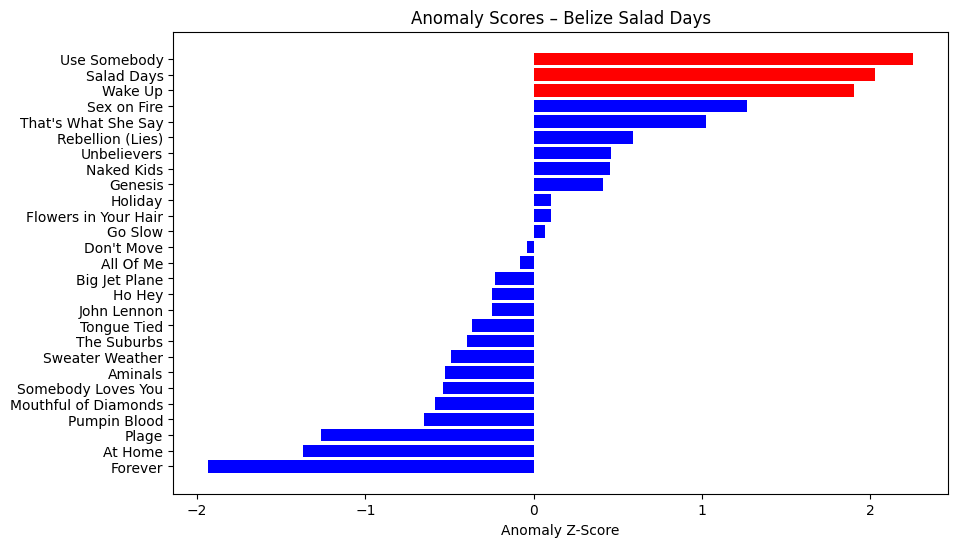

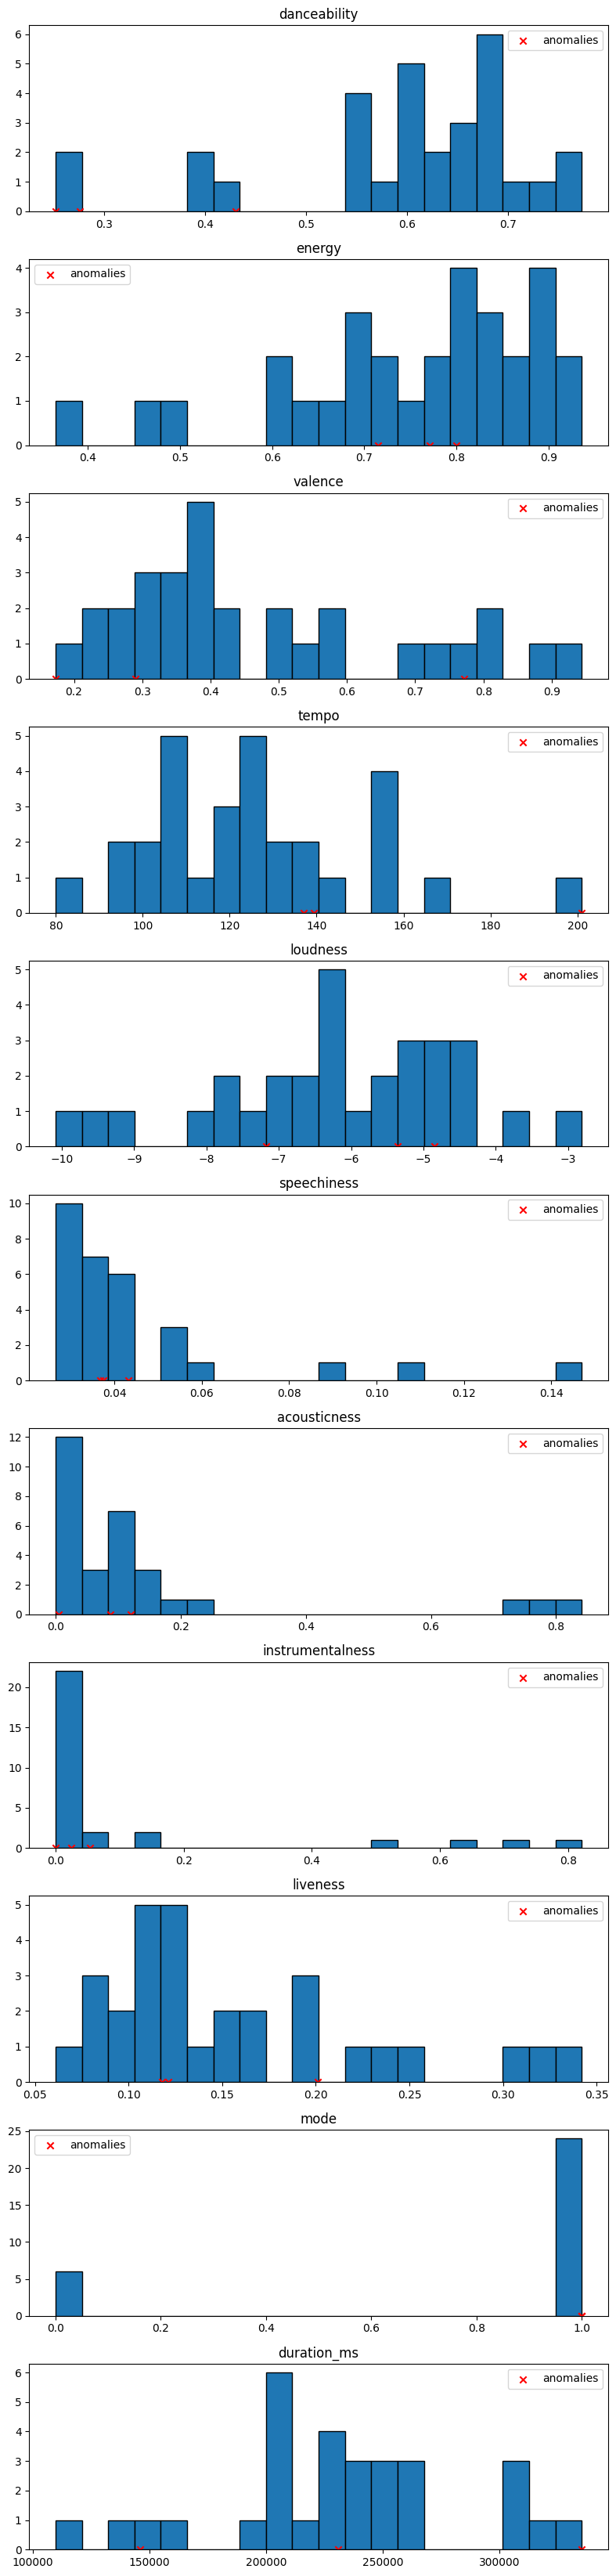

In [19]:
np.random.seed(5110)  # for reproducibility
# Run demo on a random playlist with anomalies
out_viz = demo_random_playlist_visual(
    df_work=df_work,
    df_scored=df_scored,
    global_df=global_df,
    global_scaler=global_scaler,
    global_Xs=global_Xs,
    vibe_features=vibe_features,
    require_anomalies=True,
)
# Generate all plots for the selected playlist
plot_all_for_playlist(out_viz, vibe_features, z_thresh=1.8)

## Replacement Recommendation

In [20]:
# Run comparison
comparison = compare_before_after(out_viz, vibe_features, z_thresh=1.8, k=2)


Playlist: Belize Salad Days
Replacement count (k): 2

Before replacement:
  n_tracks: 30
  mean_anomaly_z: -3.700743415417188e-17
  max_anomaly_z: 2.253006220301508
  min_anomaly_z: -1.9325737841204995
  num_above_thresh: 3
  z_thresh: 1.8

After replacement:
  n_tracks: 30
  mean_anomaly_z: 3.330667466296165e-08
  max_anomaly_z: 9.992002398888493e-07
  min_anomaly_z: -8.881779910123104e-07
  num_above_thresh: 0
  z_thresh: 1.8


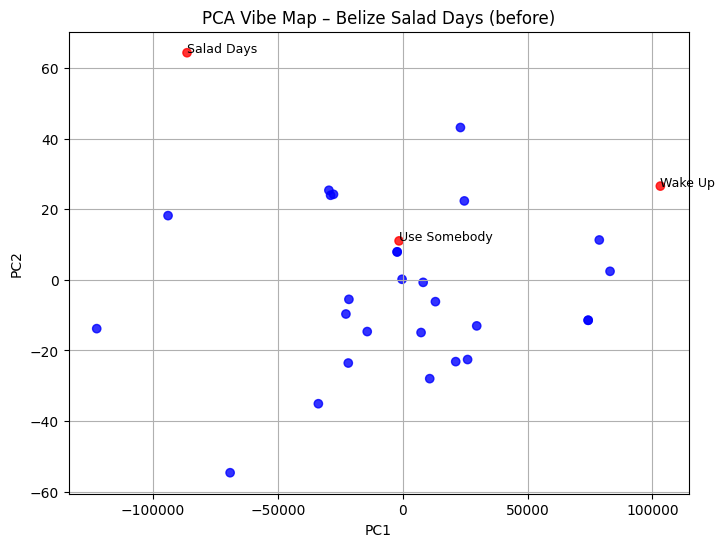

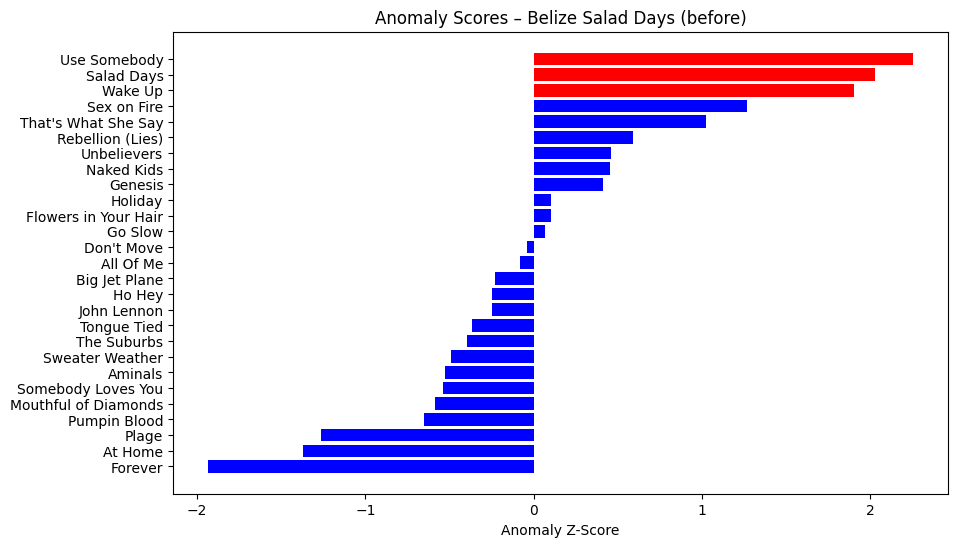

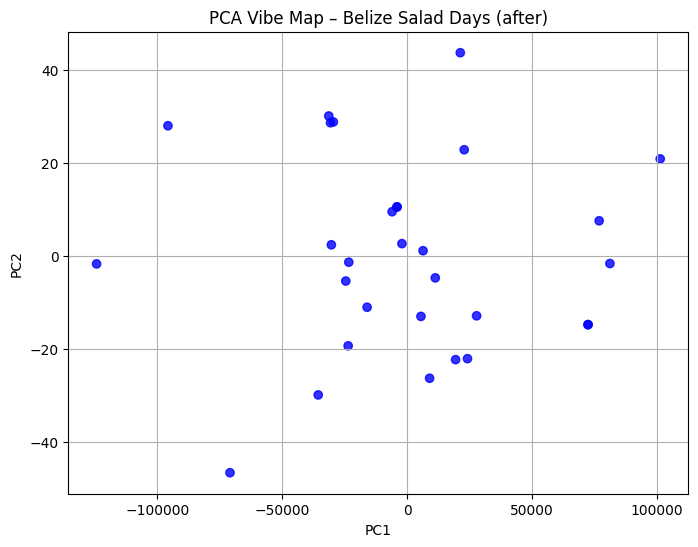

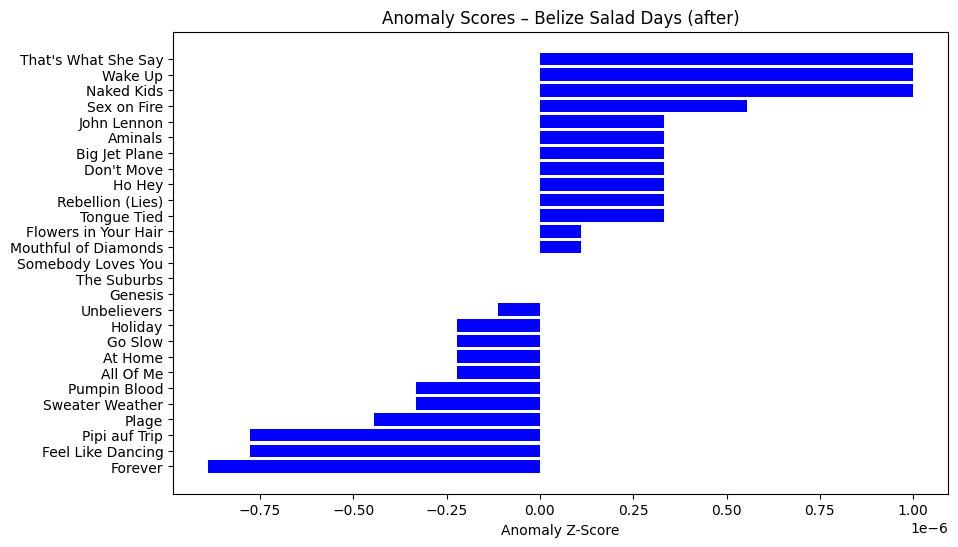

In [21]:
# Plot before vs after visuals
scored_before = comparison["scored_before"]
scored_after  = comparison["scored_after"]
pl_name = out_viz["playlist"]

# Before
plot_playlist_pca(scored_before, pl_name + " (before)", vibe_features)
plot_anomaly_bars(scored_before, pl_name + " (before)")

# After
plot_playlist_pca(scored_after, pl_name + " (after)", vibe_features)
plot_anomaly_bars(scored_after, pl_name + " (after)")

## Additional Examples


🎵 Selected playlist: Layla is 5

Anomalies found:


,artist,track,anomaly_score,anomaly_z
5368944,Michael Jackson,Rock With You,1.653302,1.959678



Recommended replacements (playlist vibe):


,id,name,artists_clean,sim_to_playlist,year,danceability,energy,valence,tempo,loudness,speechiness,acousticness,instrumentalness,liveness,mode,duration_ms
945259,1203QNdXcA043WhDaSHaML,#Алкоголичка,Artur Pirozhkov,0.936580,2019,0.830,0.906,0.780,126.981,-2.369,0.0791,0.0419,0.000002,0.1540,0,219213
730674,3TqrccsmhQjnrAKGeqo7Qy,Aladdin,Pop Girls,0.936377,2009,0.849,0.855,0.903,126.018,-4.218,0.0418,0.0231,0.000026,0.1020,0,202613
730126,71hjF8rEbKDMwhwvPMUD3s,Get It Tonight (feat. Flo Rida) (Dub Mix Mix),Erika Jayne,0.935012,2013,0.828,0.863,0.895,127.967,-4.867,0.0602,0.0041,0.004830,0.0946,0,221250
631008,5Zv9RNux1kSVdzOBe1zqpY,Are You Hungry? [Jeonghwa & Hyelin Solo],EXID,0.934837,2016,0.830,0.884,0.753,128.003,-2.845,0.0607,0.0478,0.000001,0.0983,0,198386
802632,4QtR7ybQSNok2C0gkwf3nI,Forget Me Nots,La Bouche,0.934145,2007,0.834,0.931,0.876,126.183,-5.689,0.0518,0.0038,0.000004,0.0873,0,213467


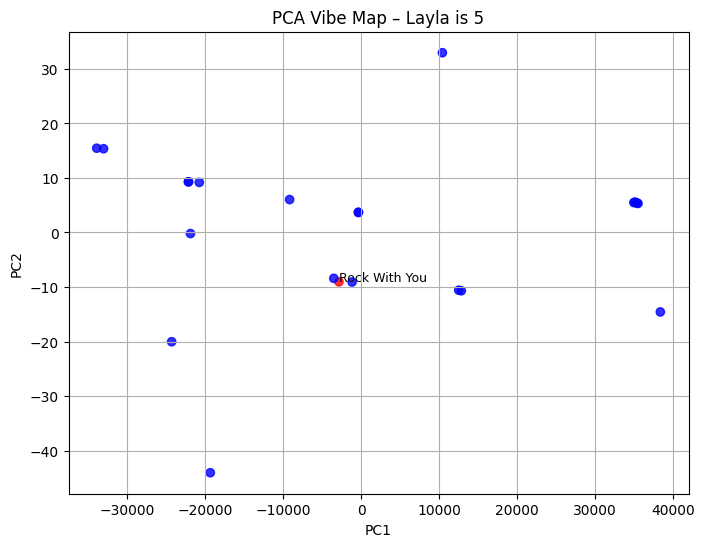

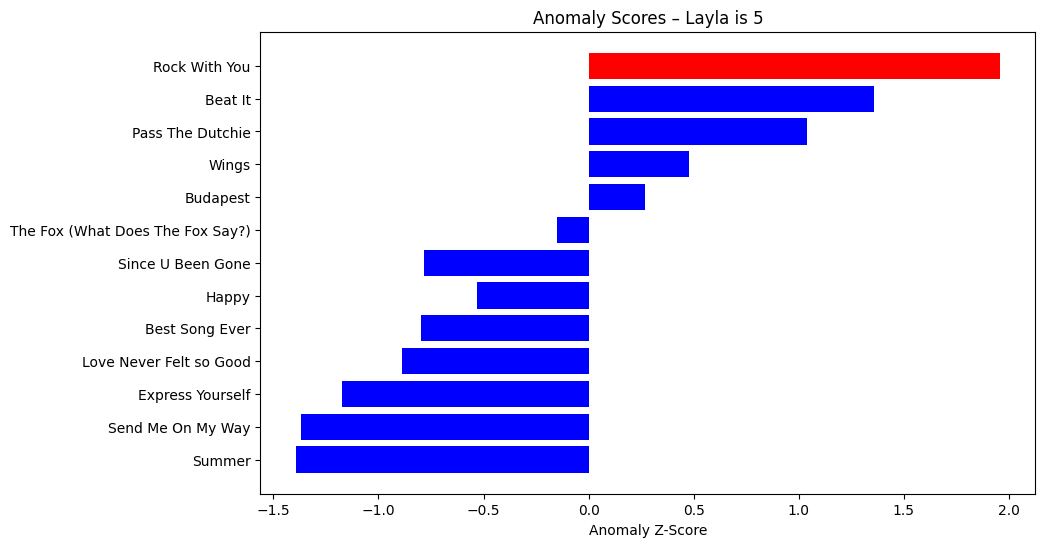

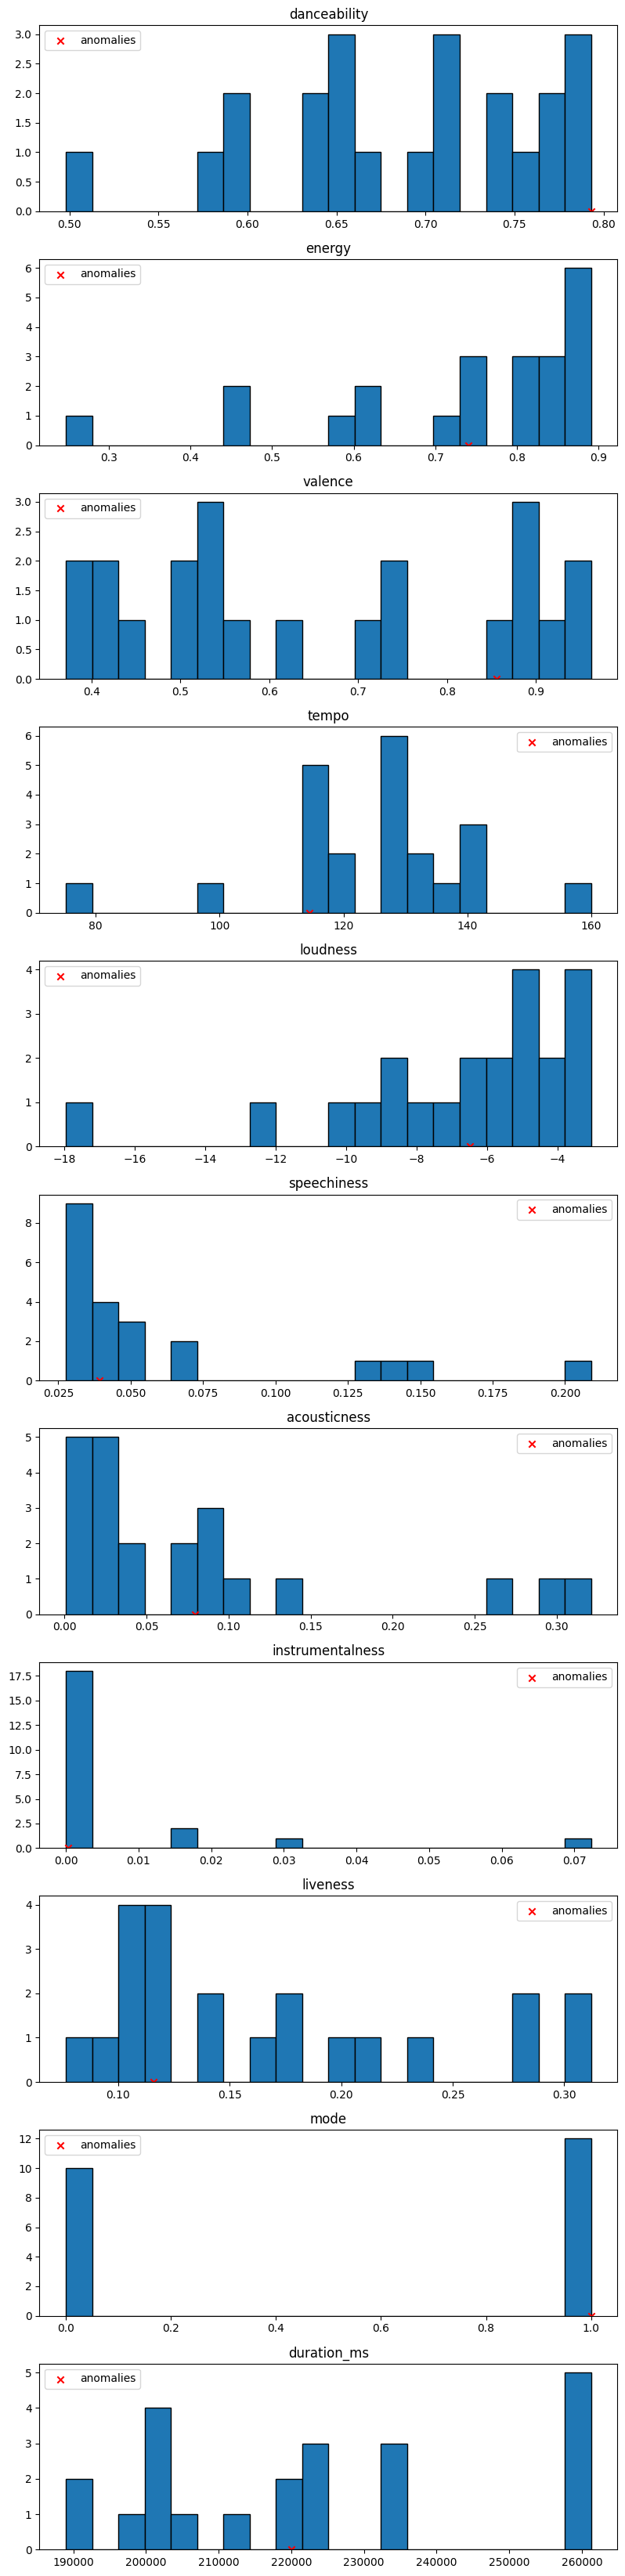


Playlist: Layla is 5
Replacement count (k): 2

Before replacement:
  n_tracks: 22
  mean_anomaly_z: -1.2111523905001707e-16
  max_anomaly_z: 1.9596782769165109
  min_anomaly_z: -1.394140372064689
  num_above_thresh: 1
  z_thresh: 1.8

After replacement:
  n_tracks: 23
  mean_anomaly_z: 8.688697171980205e-08
  max_anomaly_z: 8.881779331357542e-07
  min_anomaly_z: -8.881779331357542e-07
  num_above_thresh: 0
  z_thresh: 1.8


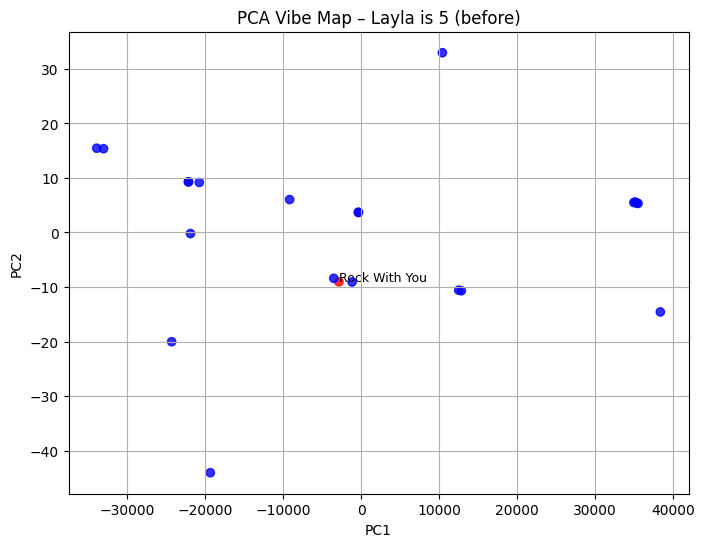

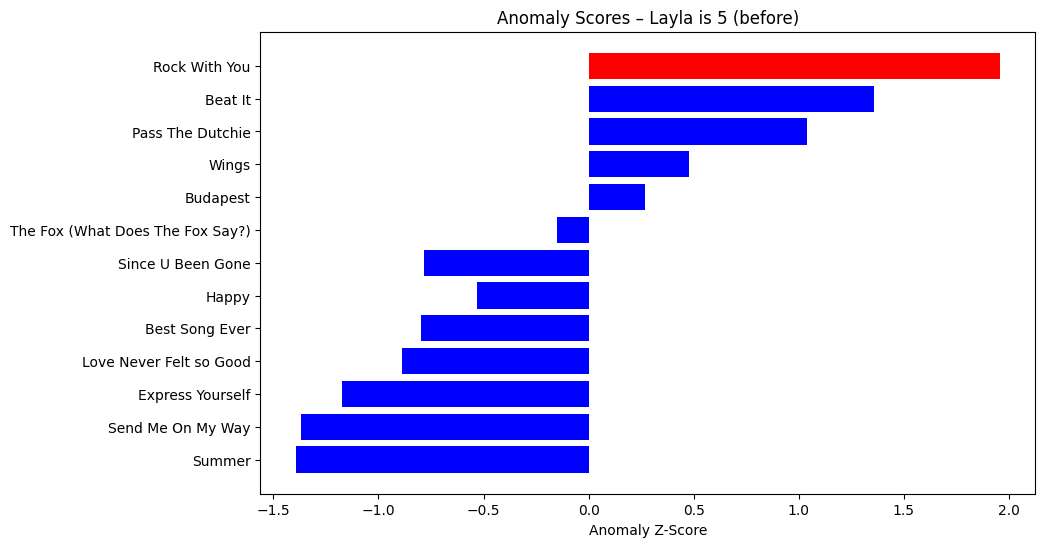

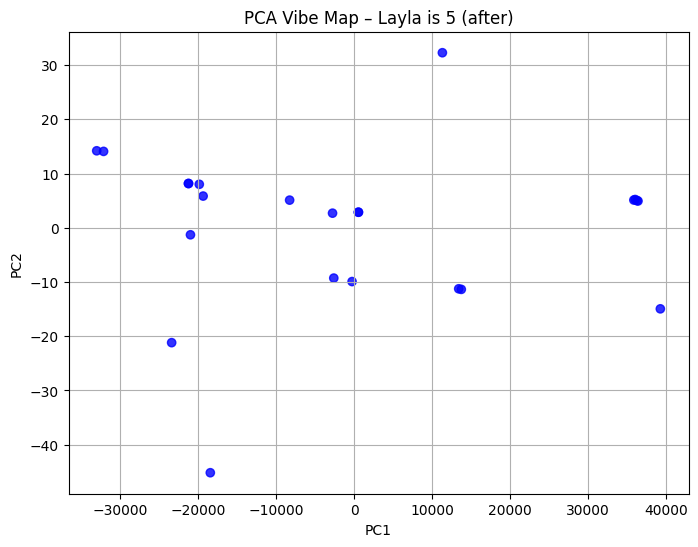

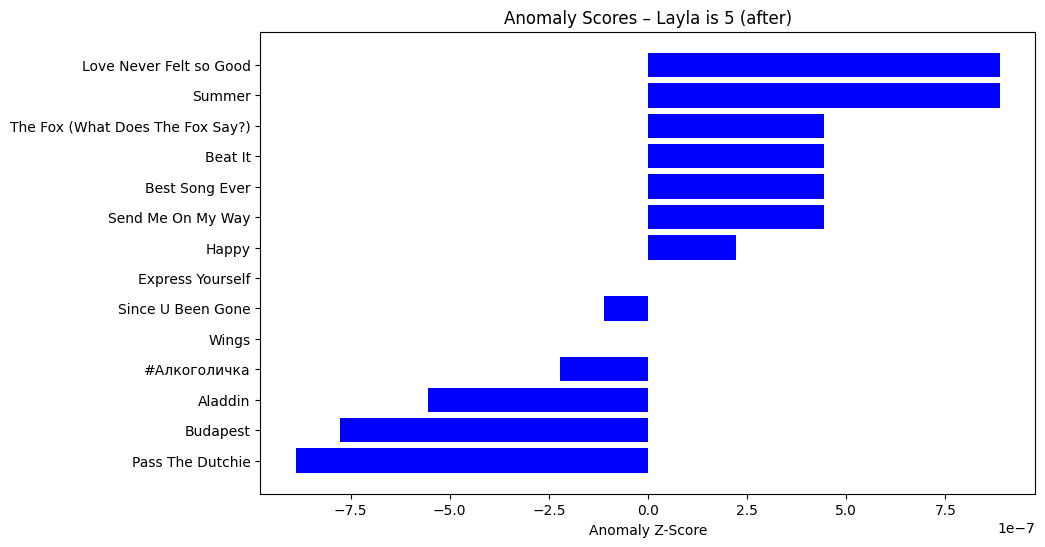

In [22]:
np.random.seed(5220)  # for reproducibility
# Run demo on a random playlist with anomalies
out_viz_0 = demo_random_playlist_visual(
    df_work=df_work,
    df_scored=df_scored,
    global_df=global_df,
    global_scaler=global_scaler,
    global_Xs=global_Xs,
    vibe_features=vibe_features,
    require_anomalies=True,
)
# Generate all plots for the selected playlist
plot_all_for_playlist(out_viz_0, vibe_features, z_thresh=1.8)

# Run comparison
comparison_0 = compare_before_after(out_viz_0, vibe_features, z_thresh=1.8, k=2)

# Plot before vs after visuals
scored_before_0 = comparison_0["scored_before"]
scored_after_0  = comparison_0["scored_after"]
pl_name_0 = out_viz_0["playlist"]

# Before
plot_playlist_pca(scored_before_0, pl_name_0 + " (before)", vibe_features)
plot_anomaly_bars(scored_before_0, pl_name_0 + " (before)")
# After
plot_playlist_pca(scored_after_0, pl_name_0 + " (after)", vibe_features)
plot_anomaly_bars(scored_after_0, pl_name_0 + " (after)")


🎵 Selected playlist: Pure Swing

Anomalies found:


,artist,track,anomaly_score,anomaly_z
6466605,Hi-Five,She's Playing Hard To Get,1.580286,2.517045
6466559,Soul For Real,Candy Rain,1.420780,1.889259
6466610,Smooth,Undercover Lover,1.400291,1.808615



Recommended replacements (playlist vibe):


,id,name,artists_clean,sim_to_playlist,year,danceability,energy,valence,tempo,loudness,speechiness,acousticness,instrumentalness,liveness,mode,duration_ms
837218,3L0NrEuL5QEFeoP0HWJZd6,Miss You,Leela James,0.946262,2009,0.812,0.566,0.771,105.992,-9.102,0.0365,0.022800,0.001570,0.0539,0,324453
148588,4dNsqegsuojih4iVjibeJY,We All Need,The Real World,0.945904,1993,0.806,0.646,0.880,102.056,-9.019,0.0362,0.032100,0.000213,0.0445,0,271360
611081,5pYbHmKlLbgZqCx0CWzdM1,The Things I'd Do,Dazz Band,0.945614,1993,0.785,0.544,0.794,95.989,-8.153,0.0327,0.012400,0.000000,0.0319,0,280387
266927,14ap7kWsS0PXsK05Y8WRLc,Mio,Moro Tovar,0.943301,2011,0.796,0.579,0.879,111.980,-8.639,0.0327,0.000812,0.000000,0.0465,0,223067
690310,5UVcgBRW78CCcKCopEGAST,Make It Happen,Mariah Carey,0.943273,1991,0.811,0.531,0.752,107.853,-8.537,0.0355,0.006570,0.028500,0.0801,0,307000


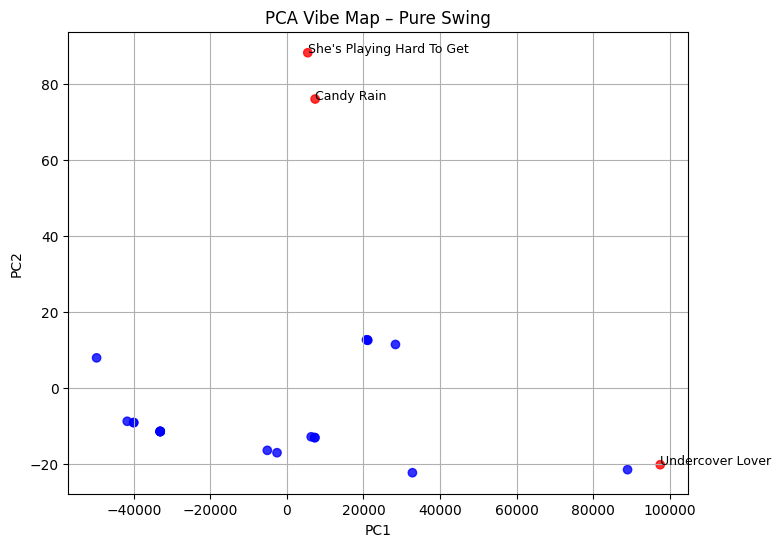

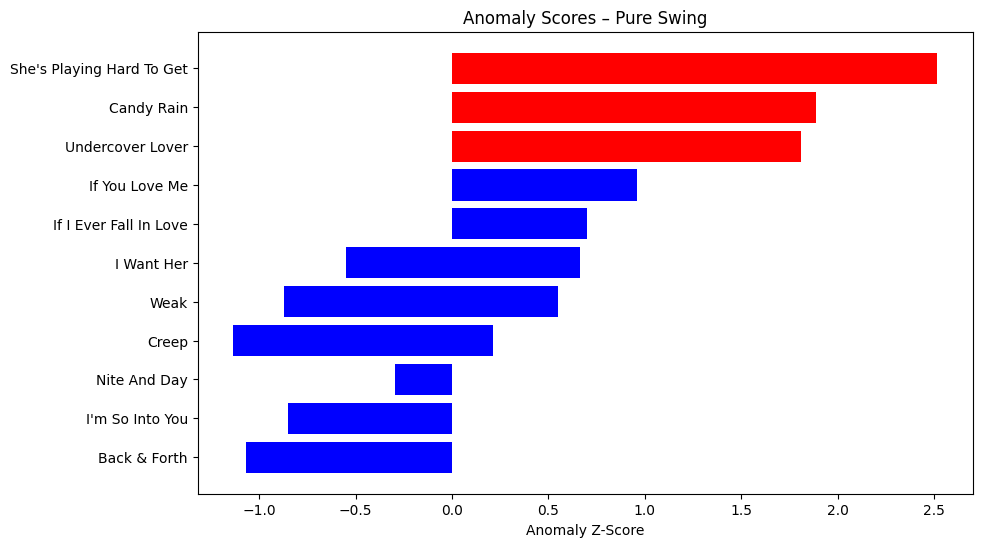

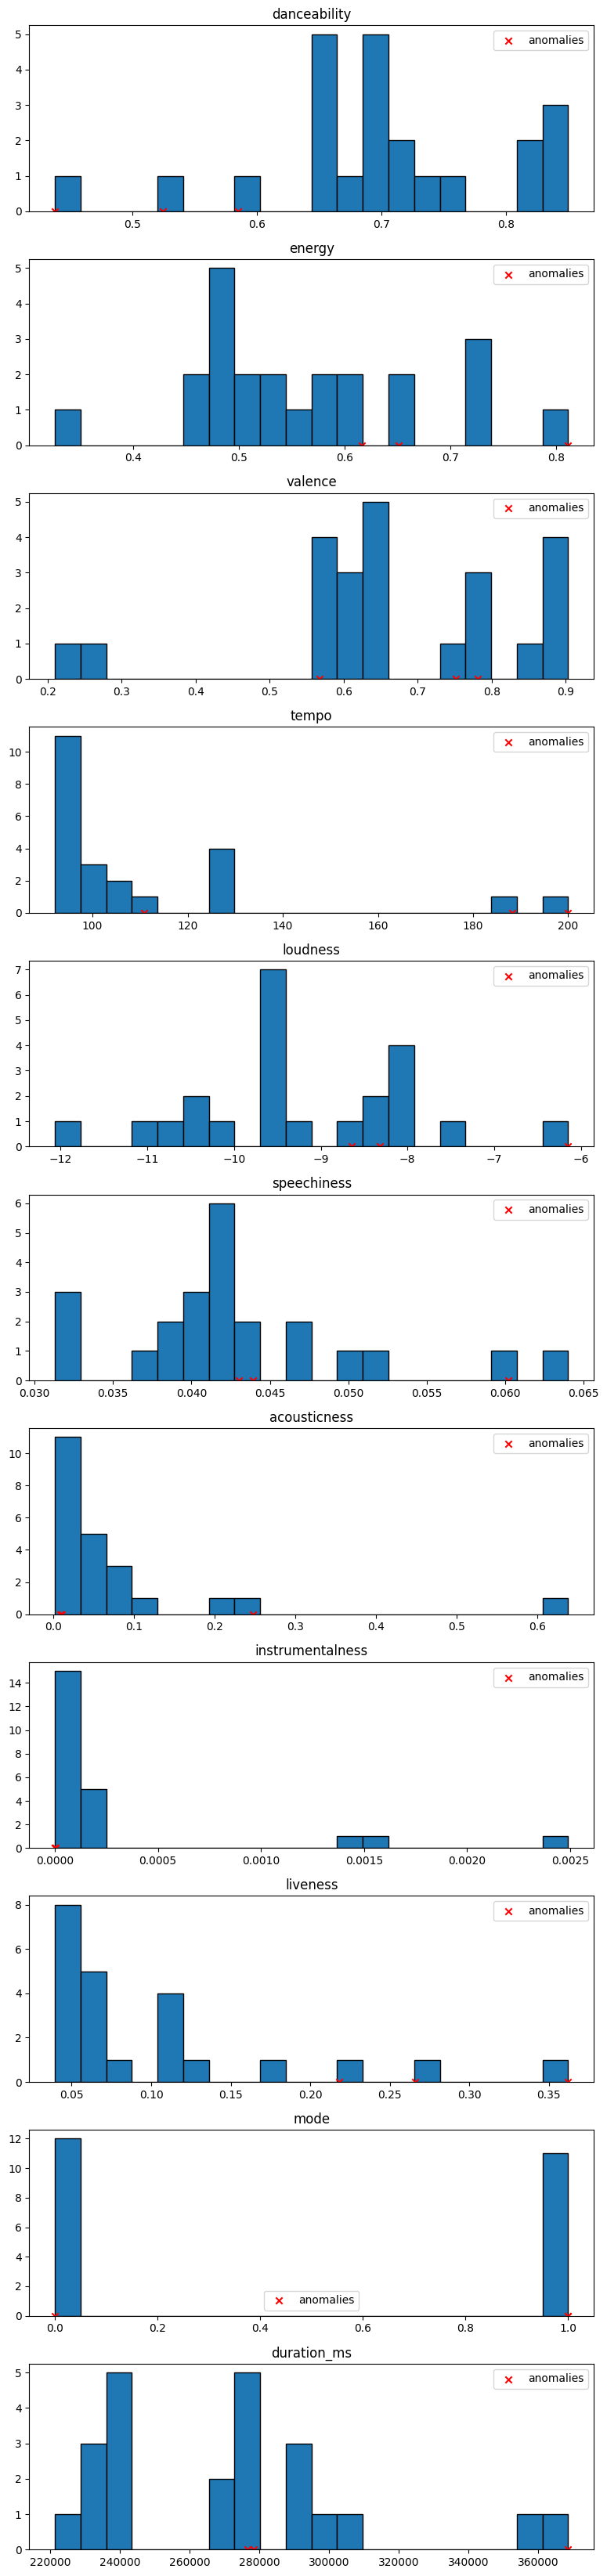


Playlist: Pure Swing
Replacement count (k): 2

Before replacement:
  n_tracks: 23
  mean_anomaly_z: -4.827056628805028e-17
  max_anomaly_z: 2.5170447622527337
  min_anomaly_z: -1.1373816495171154
  num_above_thresh: 3
  z_thresh: 1.8

After replacement:
  n_tracks: 23
  mean_anomaly_z: 2.8962322944153042e-08
  max_anomaly_z: 7.771556656681065e-07
  min_anomaly_z: -8.881779036206932e-07
  num_above_thresh: 0
  z_thresh: 1.8


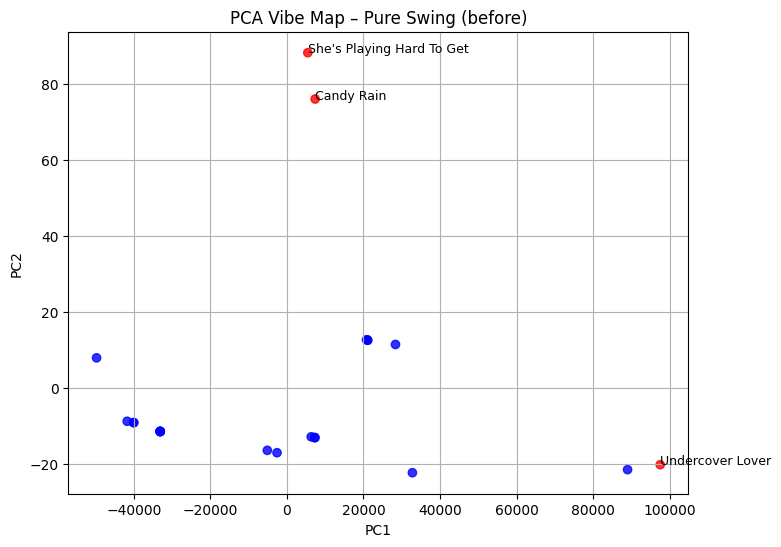

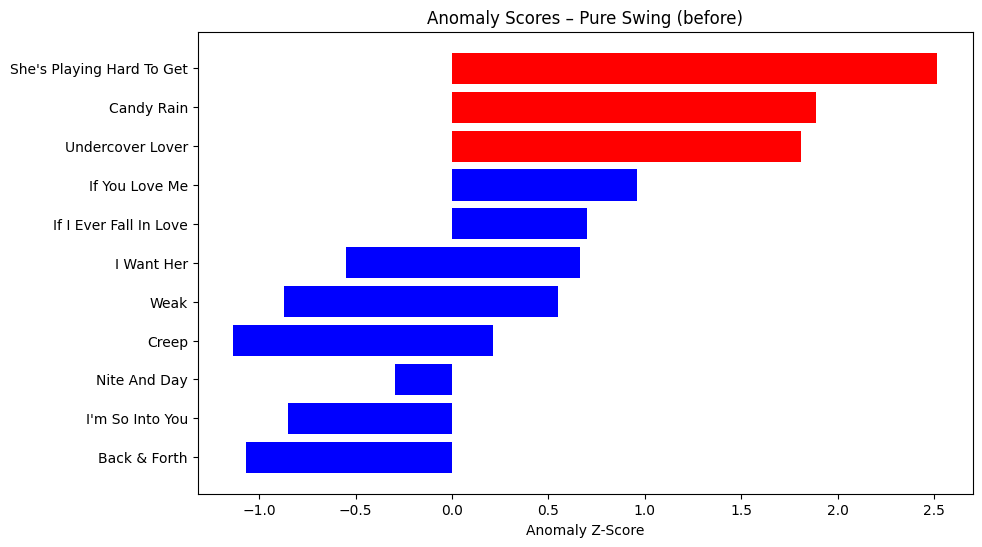

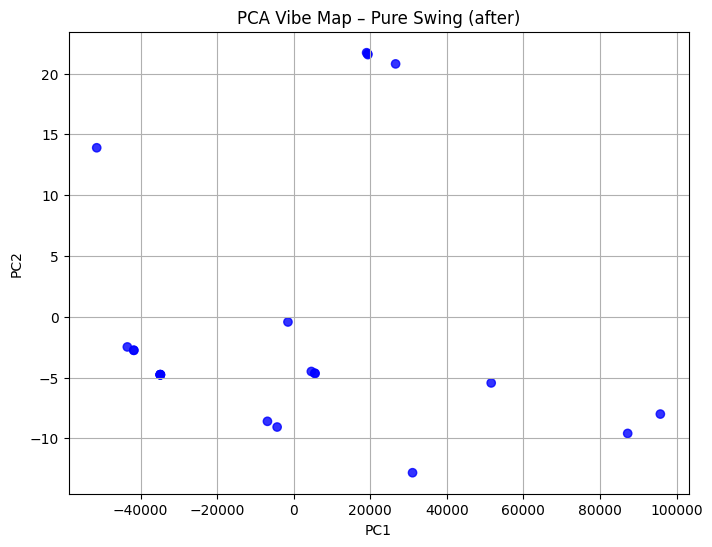

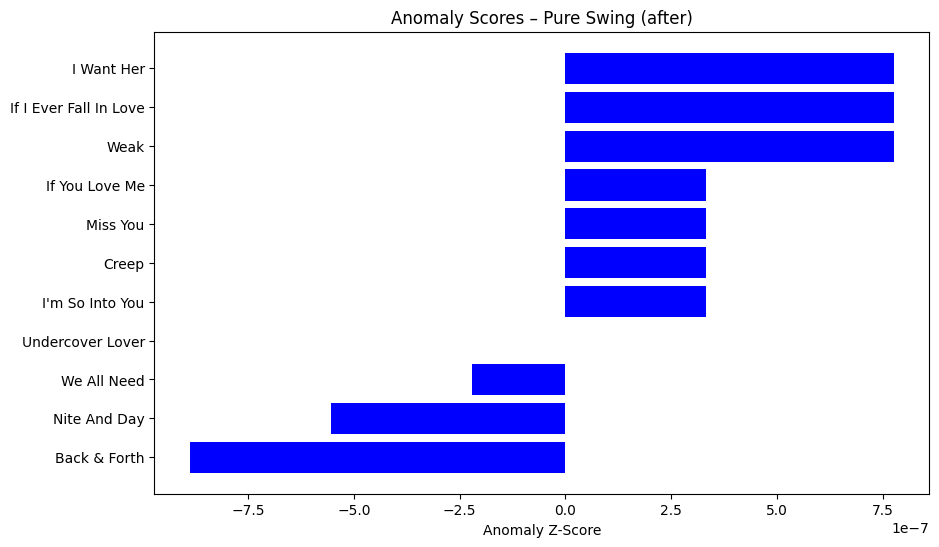

In [23]:
np.random.seed(7290)  # for reproducibility
# Run demo on a random playlist with anomalies
out_viz_1 = demo_random_playlist_visual(
    df_work=df_work,
    df_scored=df_scored,
    global_df=global_df,
    global_scaler=global_scaler,
    global_Xs=global_Xs,
    vibe_features=vibe_features,
    require_anomalies=True,
)
# Generate all plots for the selected playlist
plot_all_for_playlist(out_viz_1, vibe_features, z_thresh=1.8)

# Run comparison
comparison_1 = compare_before_after(out_viz_1, vibe_features, z_thresh=1.8, k=2)

# Plot before vs after visuals
scored_before_1 = comparison_1["scored_before"]
scored_after_1  = comparison_1["scored_after"]
pl_name_1 = out_viz_1["playlist"]

# Before
plot_playlist_pca(scored_before_1, pl_name_1 + " (before)", vibe_features)
plot_anomaly_bars(scored_before_1, pl_name_1 + " (before)")
# After
plot_playlist_pca(scored_after_1, pl_name_1 + " (after)", vibe_features)
plot_anomaly_bars(scored_after_1, pl_name_1 + " (after)")